In [963]:
# import libraries
import gym
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
import math

In [964]:
# define the first input, (position of the car)
position = ctrl.Antecedent(np.arange(0, 1, 0.01), 'position')

# define the second input, (velocity of the car)
velocity = ctrl.Antecedent(np.arange(0, 1, 0.01), 'velocity')

# define the output (action)
action = ctrl.Consequent(np.arange(0, 2, 0.1), 'action')

In [965]:
# split the inputs and output into 6 states
states_position = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']
states_velocity = ['VL', 'L', 'M', 'H', 'VH']
# states_action   = ['VL', 'L', 'M', 'H', 'VH']
states_action   = [ 'L', 'M', 'H']

# automatically divide the range on the sates (equally)
# position.automf(names = states_position)
# velocity.automf(names = states_velocity)
action.automf  (names = states_action  )

In [966]:
import numpy as np
import skfuzzy as fuzz
import skfuzzy.control as ctrl

# Define universe of discourse
position = np.linspace(0, 1, 100)
velocity = np.linspace(0, 1, 100)

# Define fuzzy variables
pos = ctrl.Antecedent(position, 'position')
vel = ctrl.Antecedent(velocity, 'velocity')
action = ctrl.Consequent(np.arange(0, 3, 1), 'action')

# Define membership functions for position
# pos['0'] = fuzz.gaussmf(position, 0.28, 0.25)    # More frequent in Action 0
pos['0'] = fuzz.gaussmf(position, 0.31, 0.11)    # More frequent in Action 0
pos['1'] = fuzz.gaussmf(position, 0.30, 0.1) # More frequent in Action 2
pos['2'] = fuzz.gaussmf(position, 0.55, 0.26)   # More frequent in Action 1

# Define membership functions for velocity
# vel['0'] = fuzz.gaussmf(velocity, 0.45, 0.1)    # More frequent in Action 0
vel['0'] = fuzz.gaussmf(velocity, 0.38, 0.11)    # More frequent in Action 0
vel['1'] = fuzz.gaussmf(velocity, 0.57, 0.06) # More frequent in Action 2
# vel['2'] = fuzz.gaussmf(velocity, 0.72, 0.1)   # More frequent in Action 1
vel['2'] = fuzz.gaussmf(velocity, 0.67, 0.15)   # More frequent in Action 1

# Define membership functions for action (discrete choices)
action['A0'] = fuzz.trimf(action.universe, [0, 0, 1])
action['A1'] = fuzz.trimf(action.universe, [0, 1, 2])
action['A2'] = fuzz.trimf(action.universe, [1, 2, 2])


c:\Users\MMM\anaconda3\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


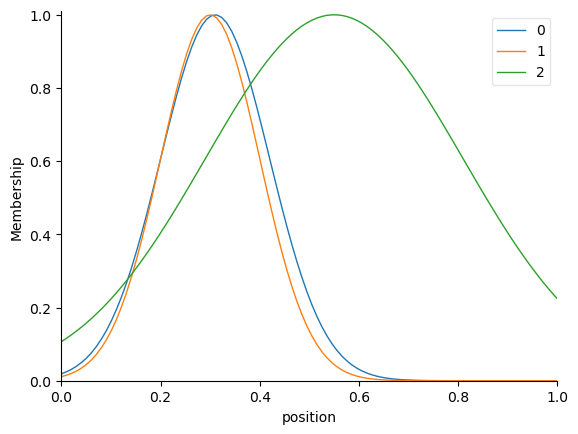

In [967]:
pos.view()

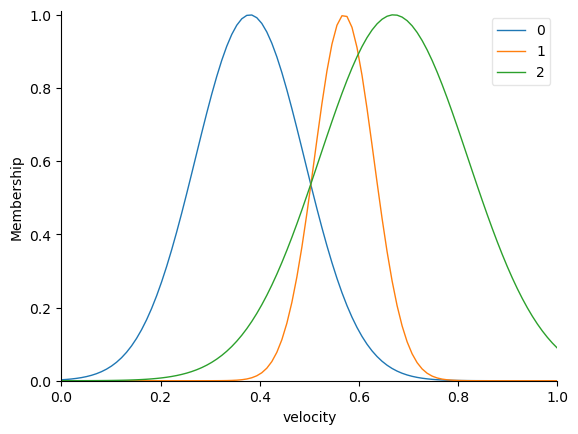

In [968]:
vel.view()

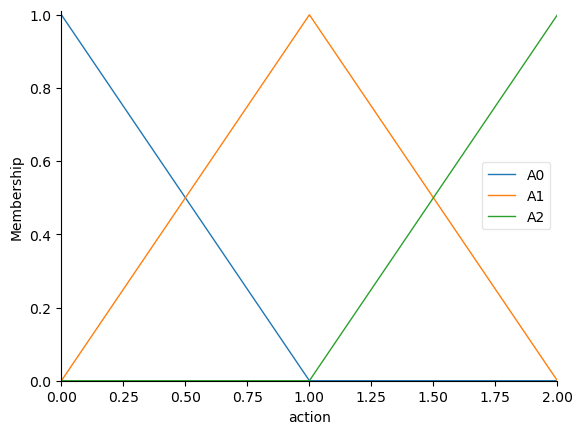

In [969]:
action.view()

In [970]:

rule1 = ctrl.Rule(pos['0'] & vel['0'], action['A0'])  # Action 0
rule2 = ctrl.Rule(pos['1'] & vel['1'], action['A1'])  # Action 2
rule3 = ctrl.Rule(vel['2'], action['A2'])  # Action 1

# rule4 = ctrl.Rule(pos['low'] & vel['medium'], action['A0'])  # Action 0
# rule5 = ctrl.Rule(pos['medium'] & vel['low'], action['A2'])  # Action 2
# rule6 = ctrl.Rule(pos['high'] & vel['medium'], action['A1'])  # Action 1


In [971]:
# # Defining rules

# # if the car is on the left side of the curve ==> high speed (give the car a push)
# rule1 = ctrl.Rule(position['low']  , action['L'])

# # if the car is trying to reach the top (x3, x4) and the velocity is low or very low ==> very low (cause it will return back)
# rule2 = ctrl.Rule((position['medium'] & velocity['high'] ), action['M'])

# # if the car is trying to reach the top (x3, x4) and the velocity is high or very high ==> very high (help the car to climb)

# # if the car is near to the top (x5, x6) ==> very high  (help the car to climb)
# rule3 = ctrl.Rule((position['high']), action['H'])

In [972]:
# define a control system based on the rules
action_ctrl = ctrl.ControlSystem([rule1, rule3])
# action_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5,rule6])

In [973]:
# make a simulation object from the control system we made
car_ctrl = ctrl.ControlSystemSimulation(action_ctrl)

In [974]:
# define a function to compute the output according to the given inputs
def get_action(state, car_ctrl):
    
    # get the position of the car
    car_ctrl.input['position'] = state[0]
    # get the velocity of the car
    car_ctrl.input['velocity'] = state[1]
    
    # compute the action
    car_ctrl.compute()
    
    # return the output
    return [car_ctrl.output['action']]

In [975]:
# creating an object ot use it as the Mountain Car environment
# environment = gym.envs.make("MountainCarContinuous-v0") 
environment = gym.envs.make("MountainCar-v0") 

# max number of steps
steps_num = 500


In [976]:
import time

In [977]:
class step_wrapper(gym.Wrapper):
    """
    A wrapper class for modifying the state and reward functions of the
    MountainCar-v0 environment.
    """

    def __init__(self, env):
        """
        Initializes the StepWrapper. This is the main class for wrapping the environment with it.

        Args:
            env (gym.Env): The environment to be wrapped.

        Attributes:
            observation_wrapper (Inherit from ObservationWrapper):
                An instance of the ObservationWrapper class for modifying observations.
            reward_wrapper (Inherit from RewardWrapper):
                An instance of the RewardWrapper class for modifying rewards.
        """
        super().__init__(env) # We give the env here to initialize the gym.Wrapper superclass (inherited).

        self.observation_wrapper = observation_wrapper(env)
        self.reward_wrapper = reward_wrapper(env)


    def step(self, action):
        """
        Executes a step in the environment with the provided action.The reason
        behind using this method is to have access to the state and reward functions return.

        Args:
            action (int): The action to be taken.
        """

        state, reward, done, truncation, info = self.env.step(action) # Same as before as usual

        modified_state = self.observation_wrapper.observation(state) # Give the state to another Wrapper, which returns a modified version of state
        modified_reward = self.reward_wrapper.reward(modified_state) # Give the modified state to another Wrapper to return the modified reward

        return modified_state, modified_reward, done, truncation, info # The same returns as usual but with modified versions of the state and reward functions


    def reset(self, seed):
        state, info = self.env.reset(seed=2024) # Same as before as usual
        modified_state = self.observation_wrapper.observation(state) # Give the state to another Wrapper, which returns a modified version of state

        return modified_state, info # Same as before as usual but with returning the modified version of the state


class observation_wrapper(gym.ObservationWrapper):
    """
    Wrapper class for modifying observations in the MountainCar-v0 environment.

    Args:
        env (gym.Env): The environment to wrap.

    Attributes:
        min_value (numpy.ndarray): Array of minimum observation values (2 dimensions because of the state.).
        max_value (numpy.ndarray): Array of maximum observation values (2 dimensions because of the state.).
    """

    def __init__(self, env):
        super().__init__(env)

        self.min_value = env.observation_space.low
        self.max_value = env.observation_space.high


    def observation(self, state):
        """
        Modifies the observation by clipping the values and normalizing it.

        Args:
            state (numpy.ndarray): The original observation from the environment.

        Returns:
            numpy.ndarray: The modified and normalized observation.
        """

        normalized_state = (state - self.min_value) / (self.max_value - self.min_value) # Min-max normalization

        return normalized_state


class reward_wrapper(gym.RewardWrapper):
    """
    Wrapper class for modifying rewards in the MountainCar-v0 environment.

    Args:
        env (gym.Env): The environment to wrap.
    """

    def __init__(self, env):
        super().__init__(env)


    def reward(self, state):
        """
        Modifies the reward based on the current state of the environment.

        Args:
            state (numpy.ndarray): The current state of the environment.

        Returns:
            float: The modified reward.
        """

        current_position, current_velocity = state # extract the position and current velocity based on the state

        # Interpolate the value to the desired range (because the velocity normalized value would be in range of 0 to 1 and now it would be in range of -0.5 to 0.5)
        current_velocity = np.interp(current_velocity, np.array([0, 1]), np.array([-0.5, 0.5]))

        # (1) Calculate the modified reward based on the current position and velocity of the car.
        degree = current_position * 360
        degree2radian = np.deg2rad(degree)
        modified_reward =  0.2 * (np.cos(degree2radian) + 2 * np.abs(current_velocity))

        # (2) Step limitation
        modified_reward -= 0.5 # Subtract 0.5 to adjust the base reward (to limit useless steps).

        # (3) Check if the car has surpassed a threshold of the path and is closer to the goal
        if current_position > 0.98:
            modified_reward += 20  # Add a bonus reward (Reached the goal)
        elif current_position > 0.92:
            modified_reward += 10 # So close to the goal
        elif current_position > 0.82:
            modified_reward += 6 # car is closer to the goal
        elif current_position > 0.65:
            modified_reward += 1 - np.exp(-2 * current_position) # car is getting close. Thus, giving reward based on the position and the further it reached


        # (4) Check if the car is coming down with velocity from left and goes with full velocity to right
        initial_position = 0.40842572 # Normalized value of initial position of the car which is extracted manually

        if current_velocity > 0.3 and current_position > initial_position + 0.1:
            modified_reward += 1 + 2 * current_position  # Add a bonus reward for this desired behavior

        return modified_reward



In [978]:
env = gym.make('MountainCar-v0', max_episode_steps=500,
                    render_mode="rgb_array_list")
env.metadata['render_fps'] = 60 # For max frame rate make it 0
env = step_wrapper(env)

In [979]:
def test(env ,max_episodes):

    # Load the weights of the test_network
    history = []
    # Testing loop over episodes
    steps = []
    rewards=[]
    failed =0
    for episode in range(1, max_episodes+1):
        frames = []
        state, _ = env.reset(24)
        done = False
        truncation = False
        step_size = 0
        episode_reward = 0

        while not done and not truncation:
            action = get_action(state, car_ctrl)
            action = action[0]

            if action<1:
                action = 0 
            else:
                action = 2


            next_state, reward, done, truncation, _ = env.step(action)
            state = next_state
            episode_reward += reward
            step_size += 1
            history.append({'state':state,'action':action})
            frames.append(env.render())
        # Print log
        if step_size>499:
            failed +=1 
        steps.append(step_size)
        rewards.append(episode_reward)
        result = (f"Episode: {episode}, "
                    f"Steps: {step_size:}, "
                    f"Reward: {episode_reward:.2f}, ")
        print(result)

    # pygame.quit() # close the rendering window
    return history,frames,steps,rewards,failed


In [980]:
_,frames,steps,rewards,failed =test(env ,1)

c:\Users\MMM\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 1, Steps: 103, Reward: 93.59, 


In [981]:
import cv2

def create_video(source, fps=60, output_name='output'):
    out = cv2.VideoWriter(output_name + '.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (source[0].shape[1], source[0].shape[0]))
    for i in range(len(source)):
        out.write(source[i])
    out.release()

In [982]:
create_video(np.array(frames[1:]).reshape(-1,400,600,3), 60, 'output')

In [983]:
print("step_mean: ",sum(steps)/len(steps))
print("reward_mean: ",sum(rewards)/len(rewards))
print("failed: ",failed)

step_mean:  103.0
reward_mean:  93.58516115821674
failed:  0
